# 📊 Demographics and Salary Analysis

This notebook explores the demographic composition, salary distribution, and tenure patterns within a public sector workforce. The goal is to identify patterns in pay equity, gender representation, and tenure, and to assess whether there are disparities worth further investigation.

We also use linear regression to test the predictive relationship between gender, tenure, and salary.

## 🔧 Data Preparation

We begin by importing and cleaning the dataset. This includes:

- Creating tenure values in years
- Defining salary bands
- Encoding gender as a numeric variable for regression


In [6]:
import pandas as pd
demo_data = "C:\\Users\\cwkru\\OneDrive\\People Analytics\\Demographics\\CLEANED_Demographics.xlsx"
demo_df = pd.read_excel(demo_data)
print((demo_df).head())

                     Department  Employee_ID         Full_Name Date_Of_Birth  \
0  Budget & Management Services         4803    Alpers Tabitha    1985-09-10   
1  Budget & Management Services        33040        Boyd Laura    1975-10-10   
2  Budget & Management Services        36129     Fuhrman Jason    1975-04-23   
3  Budget & Management Services        38883   Griffin Deramus    1983-06-03   
4  Budget & Management Services        27534  Holland Jennifer    1982-03-12   

   Hire_Date                             Job_Title Gender Salary_Basis_Code  \
0 2005-10-24      Management and Budget Analyst II      F          BIWEEKLY   
1 2023-01-09                          Secretary II      F            HOURLY   
2 2024-04-29  Senior Management and Budget Analyst      M          BIWEEKLY   
3 2025-06-02  Senior Management and Budget Analyst      M          BIWEEKLY   
4 2019-05-20  Senior Management and Budget Analyst      F          BIWEEKLY   

  Salary_Basis_Name      Salary  Tenure_Days

## 💰 Gender Distribution Across Salary Bands

This stacked bar chart visualizes how men and women are distributed across salary bands.

- While mid-range salaries show a mix of genders, higher salary bands (especially $100K+) are disproportionately male.
- This suggests possible disparities in role level, promotion, or compensation.

C:\Users\cwkru\AppData\Local\Temp\ipykernel_6836\2531084607.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gender_dist_plot = demo_df.groupby(['Salary_Band','Gender']).size().unstack(fill_value=0)


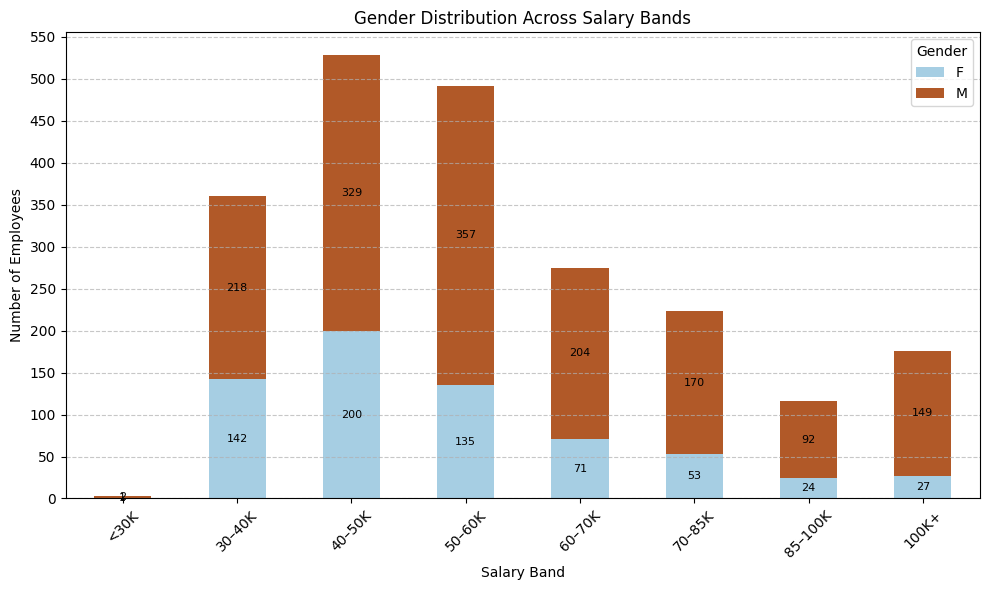

In [18]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

bins = [0, 30000, 40000, 50000, 60000, 70000, 85000, 100000, float('inf')]
labels = ['<30K', '30–40K', '40–50K', '50–60K', '60–70K', '70–85K', '85–100K', '100K+']

demo_df['Salary_Band'] = pd.cut(demo_df['Salary'], bins=bins, labels=labels, right=False)

gender_dist_plot = demo_df.groupby(['Salary_Band','Gender']).size().unstack(fill_value=0)

ax = gender_dist_plot.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Paired')
ax.set_title('Gender Distribution Across Salary Bands')
ax.set_xlabel('Salary Band')
ax.set_ylabel('Number of Employees')
ax.yaxis.set_major_locator(MultipleLocator(50)) 
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
for bar in ax.containers:
    ax.bar_label(bar, label_type='center', fontsize=8)

plt.savefig("gender_salary_distribution.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

## 👥 Gender Representation by Department

This horizontal bar chart shows the number of male and female employees in the 15 departments with the highest female headcount.

- Some departments, like **Fire Rescue** and **Roads and Drainage**, are heavily male-dominated.
- Others, such as **Health & Human Services**, show more gender balance or female-majority representation.

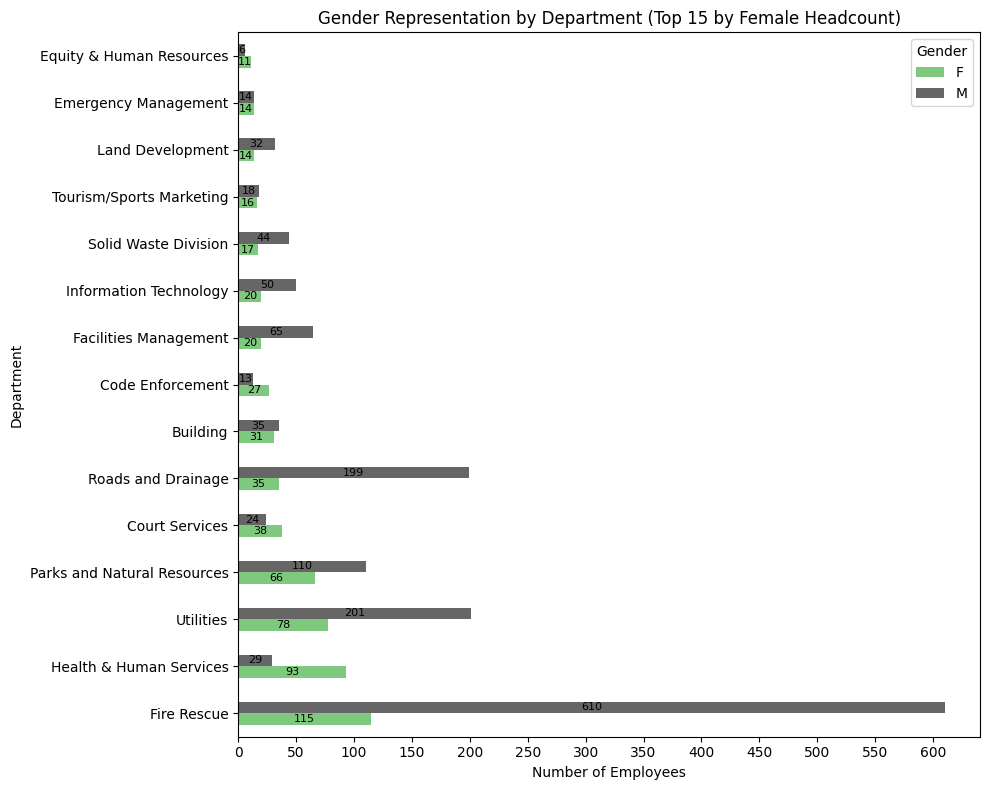

In [19]:
gender_by_dept = demo_df.groupby(['Department', 'Gender']).size().unstack(fill_value=0)

gender_by_dept = gender_by_dept.sort_values(by='F', ascending=False)

ay = gender_by_dept.head(15).plot(kind='barh', figsize=(10, 8), colormap='Accent')
ay.set_title('Gender Representation by Department (Top 15 by Female Headcount)')
ay.set_xlabel('Number of Employees')
ay.set_ylabel('Department')
ay.xaxis.set_major_locator(MultipleLocator(50))
for bar in ay.containers:
    ay.bar_label(bar, label_type='center', fontsize=8)

plt.tight_layout()
plt.savefig("gender_by_department.png", dpi=300, bbox_inches='tight')
plt.show()

## 🧠 Linear Regression: Salary Prediction

We built a linear regression model to predict salary based on:

- **Tenure** (in years)
- **Gender** (encoded: 0 = Female, 1 = Male)

This model helps assess whether gender is a statistically relevant predictor of salary after controlling for tenure.

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error

df_model = demo_df[['Salary','Tenure_Years','Gender']].dropna()

le = LabelEncoder()
df_model['Gender_encoded'] = le.fit_transform(df_model['Gender'])

X = df_model[['Tenure_Years', 'Gender_encoded']]
y = df_model['Salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Intercept:", model.intercept_)
print("Coefficients:", dict(zip(X.columns, model.coef_)))
print("R² Score:", round(r2, 4))
print("Mean Squared Error:", round(mse, 2))

Intercept: 44314.96562597689
Coefficients: {'Tenure_Years': np.float64(1374.6810960839873), 'Gender_encoded': np.float64(6735.81292010495)}
R² Score: 0.2628
Mean Squared Error: 364136412.21


## 📋 Regression Summary Table

This table summarizes the model’s coefficients and performance metrics:

- The **gender coefficient** shows that, on average, male employees earn more than females after controlling for tenure.
- The **R² score** indicates that about 26% of the variance in salary can be explained by tenure and gender.

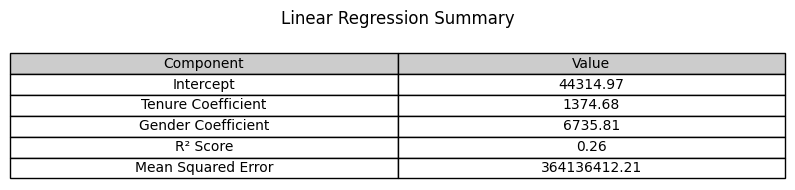

In [15]:
summary_data = {
    'Component': ['Intercept', 'Tenure Coefficient', 'Gender Coefficient', 'R² Score', 'Mean Squared Error'],
    'Value': [model.intercept_, model.coef_[0], model.coef_[1], r2, mse]
}
summary_df = pd.DataFrame(summary_data)

fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('off') 

table = ax.table(cellText=summary_df.round(2).values,
                 colLabels=summary_df.columns,
                 loc='center',
                 cellLoc='center',
                 colColours=['#cccccc'] * 2)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)

plt.title("Linear Regression Summary", pad=20)
plt.tight_layout()
plt.show()


## 📈 Actual vs Predicted Salary

This scatter plot compares the model's predictions to actual salary values.

- The red dashed line represents a perfect prediction.
- Points closer to the line are better predicted; points further away represent under- or over-prediction.

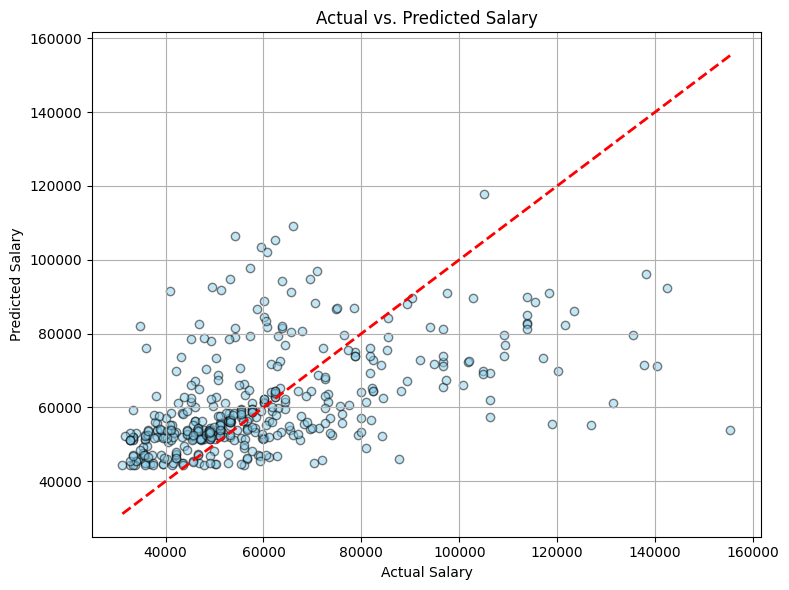

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='skyblue', edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Actual vs. Predicted Salary')
plt.grid(True)
plt.tight_layout()
plt.show()

## ✅ Summary: Key Insights & Recommendations

### 🔍 Key Insights

- **Gender Pay Gap**: After controlling for tenure, gender remains a statistically significant predictor of salary. Male employees earn approximately $6,735 more than their female counterparts, on average.
- **Salary Distribution**: The $85K+ and $100K+ salary bands are disproportionately male, suggesting underrepresentation of women in higher-paying roles or senior positions.
- **Departmental Patterns**:
  - **Fire Rescue**, **Roads and Drainage**, and **Utilities** are heavily male-dominated.
  - **Health & Human Services** and **Court Services** have stronger female representation.
- **Tenure Effects**: Each year of tenure adds about $1,375 to salary, reinforcing the value of longevity. However, even with similar tenure, gender-based disparities persist.
- **Model Performance**: The regression model explains approximately 26% of the variance in salary using just two variables (tenure and gender), indicating that additional factors (e.g., job title, department, performance) should be considered in future models.

---

### 💡 Recommendations

- **Conduct a deeper pay equity analysis** that controls for job title, department, and performance ratings in addition to gender and tenure.
- **Audit promotion and compensation practices** in male-dominated departments to assess barriers to advancement for women.
- **Invest in mentorship and leadership development** targeted at improving female representation in upper salary bands.
- **Explore potential tenure-related retention strategies** for early-career employees, especially in departments with higher turnover or less pay equity.

---

This analysis provides a foundational look at potential equity concerns and highlights areas where data-driven workforce strategies can support inclusion and transparency.